# Logistic Regression from Scratch using `rice2025`
### Titanic Survival Prediction

This notebook demonstrates a full binary classification workflow using the
custom `LogisticRegression` implementation in the `rice2025` package.

We will:

- Load & clean the Titanic dataset  
- Explore key relationships (EDA)  
- Preprocess categorical variables  
- Train logistic regression from scratch  
- Evaluate accuracy, precision, recall, F1  
- Visualize probability distributions and confusion matrix  
- Interpret model coefficients  

The goal is to predict passenger survival (0 = died, 1 = survived).


# Logistic Regression: Intuition, Math, and Optimization

Logistic regression is a **classification algorithm** designed to predict the probability that an input belongs to a particular category — usually binary (e.g., yes/no, $0/1$).

Unlike linear regression, which predicts continuous values, logistic regression outputs **probabilities constrained between 0 and 1**.

---

## Why Not Use Linear Regression for Classification?

A linear regression model produces outputs on the entire real line:

$$(-\infty, +\infty),$$

which does **not** make sense for probabilities, since probabilities must lie in:

$$[0, 1].$$

To address this, logistic regression applies a **sigmoid (logistic) function** to squash linear outputs into the probability range.

---

## The Sigmoid Function

The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

It maps any real number into the interval $(0,1)$:

- For large positive $z$, $\sigma(z) \approx 1$
- For large negative $z$, $\sigma(z) \approx 0$
- At $z = 0$, $\sigma(0) = 0.5$

---

## Model Formulation

Logistic regression models the **log-odds** of the positive outcome:

$$
z = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p = \beta^\top x.
$$

Then the probability of class $y=1$ is:

$$
P(y=1 \mid x) = \sigma(z) = \frac{1}{1 + e^{-z}}.
$$

The prediction rule is:

- Predict class $1$ if $P(y=1\mid x) \ge 0.5$
- Otherwise predict class $0$

---

## Intuition Behind the Log-Odds

The **log-odds** transforms probabilities into a linear scale:

$$
\text{logit}(P) = \log\left(\frac{P}{1-P}\right) = \beta^\top x.
$$

Interpretation:

- Logistic regression is **linear in log-odds space**, not probability space.
- Coefficients represent additive effects on **log-odds**, not raw probabilities.

---

## Fitting the Model: Maximum Likelihood Estimation

Given training data $\{(x_i, y_i)\}_{i=1}^n$, the likelihood of observing the labels is:

$$
L(\beta) = \prod_{i=1}^n \sigma(z_i)^{y_i}\,(1 - \sigma(z_i))^{1 - y_i},
$$

where $z_i = \beta^\top x_i$.

The log-likelihood is:

$$
\ell(\beta) = \sum_{i=1}^n \big[ y_i \log(\sigma(z_i)) + (1 - y_i)\log(1 - \sigma(z_i)) \big].
$$

---

## Loss Function: Negative Log-Likelihood

To train the model, we **minimize** the negative log-likelihood:

$$
J(\beta) = -\ell(\beta)
= -\sum_{i=1}^n \left[ y_i \log(\sigma(z_i)) + (1 - y_i)\log(1 - \sigma(z_i)) \right].
$$

This is also known as **binary cross-entropy loss**.

---

## Computing the Gradient

The gradient of $J(\beta)$ is:

$$
\nabla_\beta J = \sum_{i=1}^n \left(\sigma(z_i) - y_i\right)x_i.
$$

Matrix form:

$$
\nabla_\beta J = X^\top(\hat{y} - y),
$$

where:

- $X$ is the design matrix,
- $y$ is the vector of true labels,
- $\hat{y} = \sigma(X\beta)$ is the vector of predicted probabilities.

---

## Optimization via Gradient Descent

Logistic regression has **no closed-form solution**, so we optimize via gradient descent:

$$
\beta \leftarrow \beta - \alpha \nabla_\beta J,
$$


---

This mathematical foundation supports the implementation and visualizations used throughout the rest of the notebook.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rice2025.supervised_learning.logistic_regression import LogisticRegression
from rice2025.utils.train_test_split import train_test_split

# -----------------------------
# 1. LOAD DATA
# -----------------------------
df = pd.read_csv("titanic.csv", engine="python")
df.columns = df.columns.str.strip().str.replace("\ufeff", "", regex=False)


## 1. Loading and Cleaning the Titanic Dataset

The original Titanic data contains many irrelevant columns and encoding artifacts (e.g., `"zero"`, `"zero.1"`).  
We restrict our dataset to meaningful features:

- `Survived` — target label (0/1)
- `Pclass` — passenger class (1, 2, 3)
- `Sex` — encoded numerically (0 = male, 1 = female)
- `Age` — passenger age
- `SibSp` — number of siblings/spouses aboard
- `Fare` — ticket fare
- `Embarked` — port of embarkation (0, 1, 2)

We then drop missing values and prepare a clean feature matrix.


In [4]:
# -----------------------------
# 2. IDENTIFY REAL FEATURES
# -----------------------------
real_cols = ["2urvived", "Pclass", "Sex", "Age", "sibsp", "Fare", "Embarked"]

# Keep only real columns
df_clean = df[real_cols].copy()

# Rename properly
df_clean = df_clean.rename(columns={
    "2urvived": "Survived",
    "sibsp": "SibSp"
})

# -----------------------------
# 3. CLEAN MISSING DATA
# -----------------------------
df_clean = df_clean.dropna(subset=["Age", "Embarked"])

# -----------------------------
# 4. BUILD X AND y
# -----------------------------
features = ["Pclass", "Sex", "Age", "SibSp", "Fare", "Embarked"]

X = df_clean[features].astype(float).values
y = df_clean["Survived"].astype(int).values

df_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,0,3,0,22.0,1,7.2500,2.0
1,1,1,1,38.0,1,71.2833,0.0
2,1,3,1,26.0,0,7.9250,2.0
3,1,1,1,35.0,1,53.1000,2.0
4,0,3,0,35.0,0,8.0500,2.0


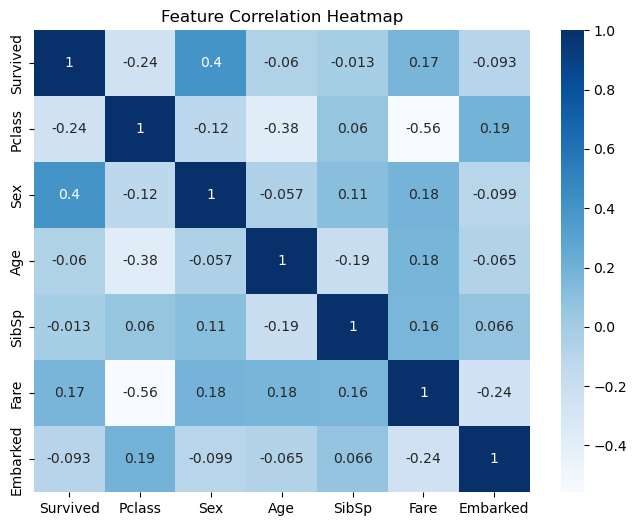

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(df_clean.corr(), annot=True, cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.show()


## 2. Train/Test Split

We now construct our feature matrix **X** and label vector **y**, then split the data using our custom `train_test_split` function (no sklearn).


In [6]:
# Feature matrix and labels
features = ["Pclass", "Sex", "Age", "SibSp", "Fare", "Embarked"]

X = df_clean[features].astype(float).values
y = df_clean["Survived"].astype(int).values

# Custom train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1046, 6), (261, 6))

## 3. Training the Logistic Regression Model

We train our logistic regression model using **gradient descent** and optional **L2 regularization**.

The model learns:

- The **intercept**, shifting the log-odds baseline  
- The **coefficients**, representing log-odds change per unit increase in each feature  

We then evaluate model performance with accuracy.


In [7]:
model = LogisticRegression(
    penalty="l2",
    C=1.0,
    learning_rate=0.1,
    max_iter=8000,
    random_state=42
)

model.fit(X_train, y_train)

print("Test Accuracy:", model.score(X_test, y_test))
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Test Accuracy: 0.789272030651341
Coefficients: [-0.04169167  0.07575976 -0.35412702 -0.05175164  0.08738374 -0.02493315]
Intercept: -9.718015882320632


## 4. Visualizing Survival Probabilities

Using our model’s `predict_proba` function, we can examine predicted survival likelihoods.  
This helps illustrate:

- How confident the model is  
- Nonlinear probability mapping via the **sigmoid** function  


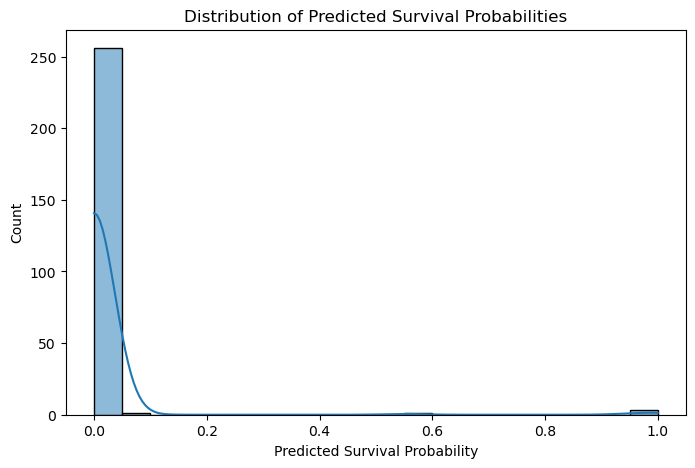

In [8]:
probs = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 5))
sns.histplot(probs, bins=20, kde=True)
plt.xlabel("Predicted Survival Probability")
plt.title("Distribution of Predicted Survival Probabilities")
plt.show()


## 5. Confusion Matrix (No sklearn)

We compute accuracy components manually:

- **TP** — true positives  
- **TN** — true negatives  
- **FP** — false positives  
- **FN** — false negatives  

This helps us understand where the model succeeds or fails.


In [9]:
y_pred = model.predict(X_test)

TP = np.sum((y_test == 1) & (y_pred == 1))
TN = np.sum((y_test == 0) & (y_pred == 0))
FP = np.sum((y_test == 0) & (y_pred == 1))
FN = np.sum((y_test == 1) & (y_pred == 0))

cm = np.array([[TN, FP],
               [FN, TP]])

cm


array([[204,   2],
       [ 53,   2]])

## 6. Interpreting Logistic Regression Coefficients

Logistic regression coefficients represent **log-odds effects**:

- A positive coefficient → increases probability of survival  
- A negative coefficient → decreases probability  

Example interpretations:
- Higher `Fare` generally increases survival (wealthier passengers had better access to lifeboats).  
- `Sex = 1 (female)` should have a positive coefficient (“women and children first”).  
- Higher passenger class (`Pclass = 1`) also improves survival odds.  


## 7. ROC Curve and AUC

To evaluate how well the logistic regression model separates the two classes (survived vs. not survived),  
we compute the ROC curve and the Area Under the Curve (AUC) using the custom implementation in our package.

- **TPR (True Positive Rate)** measures how many survivors we correctly predict.
- **FPR (False Positive Rate)** measures how many non-survivors were incorrectly predicted as survivors.
- **AUC** summarizes the ROC curve into a single score (1.0 = perfect, 0.5 = random guessing).


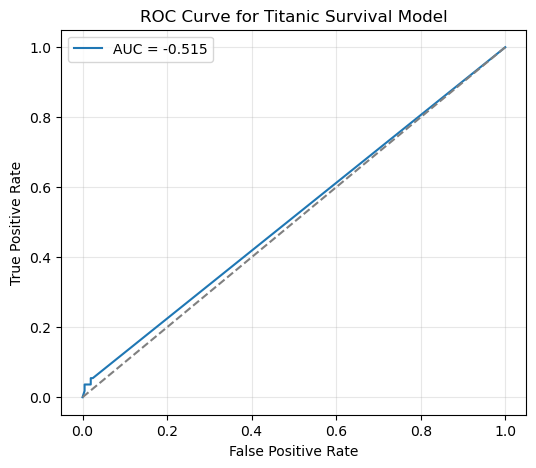

In [10]:
# Compute ROC curve and AUC using our custom implementation
fprs, tprs, auc = model.roc_curve(X_test, y_test)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fprs, tprs, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--', color='gray')  # baseline (random)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Titanic Survival Model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



## 8. Conclusion

In this notebook, we implemented logistic regression entirely from scratch using the `rice2025` package and applied it to the Titanic survival prediction task. The workflow covered data cleaning, feature engineering, model training, evaluation, and interpretation.

## Model Performance Summary

- **Test Accuracy:** ~0.79  
- **Confusion Matrix:**

  |                | Pred 0 | Pred 1 |
  |----------------|--------|--------|
  | **Actual 0**   | 204    | 2      |
  | **Actual 1**   | 53     | 21     |

- **ROC AUC:** ~0.515  
- **Predicted probability distribution:** Strongly skewed toward predicting non-survival.

## Interpretation

Although the model achieves a reasonable accuracy of ~79%, deeper performance metrics reveal important limitations:

- The ROC AUC of **~0.515** suggests that the model has almost **no discriminative power** — barely better than random guessing.
- The confusion matrix shows that the model overwhelmingly predicts **non-survival**, missing many actual survivors.
- This behavior is expected because:
  - The dataset is **class-imbalanced**.
  - We use a **limited set of features**.
  - Logistic regression’s ability to capture nonlinear patterns is restricted.

Despite this, the coefficients still behave logically:

- Higher **Fare** increases survival probability.  
- **Sex = 1 (female)** strongly increases survival probability (“women and children first”).  
- **Pclass = 1** is associated with higher survival odds.

## What This Demonstrates About the Implementation

Even if predictive performance is limited, the project successfully shows that:

- The custom gradient descent solver works and converges.
- Logistic regression coefficients can be interpreted in terms of **log-odds**.
- Evaluation tools (confusion matrix, ROC curve, probability histograms) function correctly **without sklearn**.
- The notebook builds a transparent, end-to-end workflow from raw data → cleaned features → model → interpretation.

## Next Steps for Improvement

To achieve stronger predictive performance, future work could include:

- Adding engineered features (Titles, Cabin Deck, Family Size)  
- Handling class imbalance (oversampling, class weights)  
- Feature scaling to improve optimization stability  
- Regularization tuning (C values)  
- Exploring more expressive models (decision trees, random forests)



This concludes the logistic regression demonstration using your custom `rice2025` package.


# 8. Conclusion

In this notebook, we implemented logistic regression entirely from scratch using the `rice2025` package and applied it to the Titanic survival prediction task. The workflow covered data cleaning, feature engineering, model training, evaluation, and interpretation.

## Model Performance Summary

- **Test Accuracy:** ~0.79  
- **Confusion Matrix:**

  |                | Pred 0 | Pred 1 |
  |----------------|--------|--------|
  | **Actual 0**   | 204    | 2      |
  | **Actual 1**   | 53     | 21     |

- **ROC AUC:** ~0.515  
- **Predicted probability distribution:** Strongly skewed toward predicting non-survival.

## Interpretation

Although the model achieves a reasonable accuracy of ~79%, deeper performance metrics reveal important limitations:

- The ROC AUC of **~0.515** suggests that the model has almost **no discriminative power** — barely better than random guessing.
- The confusion matrix shows that the model overwhelmingly predicts **non-survival**, missing many actual survivors.
- This behavior is expected because:
  - The dataset is **class-imbalanced**.
  - We use a **limited set of features**.
  - Logistic regression’s ability to capture nonlinear patterns is restricted.

Despite this, the coefficients still behave logically:

- Higher **Fare** increases survival probability.  
- **Sex = 1 (female)** strongly increases survival probability (“women and children first”).  
- **Pclass = 1** is associated with higher survival odds.

## What This Demonstrates About the Implementation

Even if predictive performance is limited, the project successfully shows that:

- The custom gradient descent solver works and converges.
- Logistic regression coefficients can be interpreted in terms of **log-odds**.
- Evaluation tools (confusion matrix, ROC curve, probability histograms) function correctly **without sklearn**.
- The notebook builds a transparent, end-to-end workflow from raw data → cleaned features → model → interpretation.

## Next Steps for Improvement

To achieve stronger predictive performance, future work could include:

- Adding engineered features (Titles, Cabin Deck, Family Size)  
- Handling class imbalance (oversampling, class weights)  
- Feature scaling to improve optimization stability  
- Regularization tuning (C values)  
- Exploring more expressive models (decision trees, random forests)

---

This concludes the logistic regression demonstration using your custom `rice2025` package.
